In [40]:
from pathlib import Path
from dataclasses import dataclass

import numpy as np
import ezmsg.core as ez
import matplotlib.pyplot as plt

from ezmsg.util.messages.axisarray import AxisArray

from ezmsg.util.messagelogger import (
    MessageReplay, 
    MessageReplaySettings,
    MessageCollector, 
    MessageCollectorSettings,
)

from ezmsg.ssvep.spectralstats import SpectralStats, SpectralStatsSettings

from typing import List, Any


In [41]:
@dataclass(frozen = True)
class OfflineStatsSettingsMessage:
    replay_settings: MessageReplaySettings
    stats_settings: SpectralStatsSettings

class OfflineStatsSettings(ez.Settings, OfflineStatsSettingsMessage):
    ...

class OfflineStats(ez.Collection):
    SETTINGS: OfflineStatsSettings

    REPLAY = MessageReplay()
    STATS = SpectralStats()
    COLLECTOR = MessageCollector()

    def configure(self) -> None:
        self.REPLAY.apply_settings(self.SETTINGS.replay_settings)
        self.STATS.apply_settings(self.SETTINGS.stats_settings)
        self.COLLECTOR.apply_settings(
            MessageCollectorSettings(
                term_on_total = True
            )
        )

    def network(self) -> ez.NetworkDefinition:
        return (
            (self.REPLAY.OUTPUT_MESSAGE, self.STATS.INPUT_SAMPLE),
            (self.STATS.OUTPUT_STATS, self.COLLECTOR.INPUT),
            (self.REPLAY.OUTPUT_TOTAL, self.COLLECTOR.INPUT_TOTAL),
        )
    
    @property
    def output(self) -> List[Any]:
        return self.COLLECTOR.messages

2023-02-27 09:52:53.255 - pid: 69402 - TaskThread - INFO - ensure_running: Started SHMServer. PID:73999@127.0.0.1:25979
2023-02-27 09:52:53.336 - pid: 69402 - TaskThread - INFO - ensure_running: Started GraphServer. PID:74000@127.0.0.1:25978
2023-02-27 09:52:53.418 - pid: 69402 - TaskThread - INFO - update_stats: Insufficient number of observations
2023-02-27 09:52:53.992 - pid: 69402 - TaskThread - INFO - pub_messages: Replayed 20 messages from /Users/milsagw1/ssvep_data/SSVEP_S1/15Hzx20_20230224T165259.txt
2023-02-27 09:52:54.183 - pid: 69402 - TaskThread - INFO - wrapped_task: OfflineStats/REPLAY:pub_messages Complete
2023-02-27 09:52:57.170 - pid: 69402 - TaskThread - INFO - wrapped_task: Normal Termination raised in OfflineStats/COLLECTOR:on_message
2023-02-27 09:52:57.173 - pid: 69402 - MainThread - INFO - run: All processes exited normally
2023-02-27 09:52:57.193 - pid: 69402 - TaskThread - INFO - _shutdown_servers: Terminating GraphServer
2023-02-27 09:52:57.201 - pid: 69402 - 

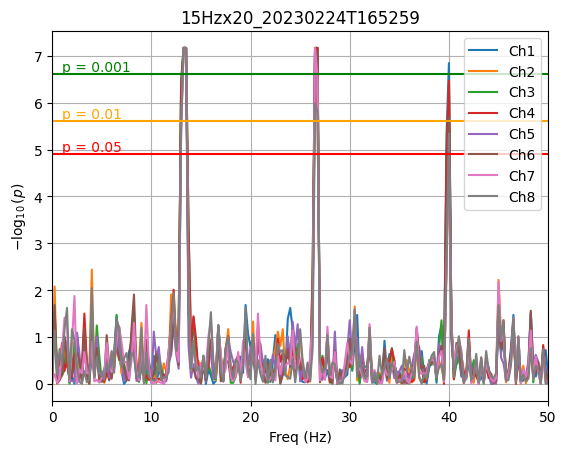

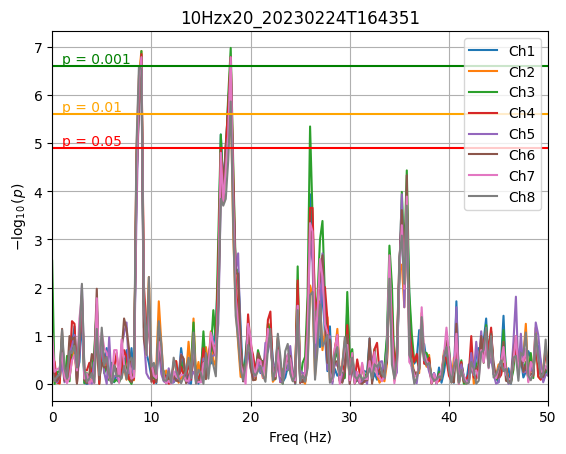

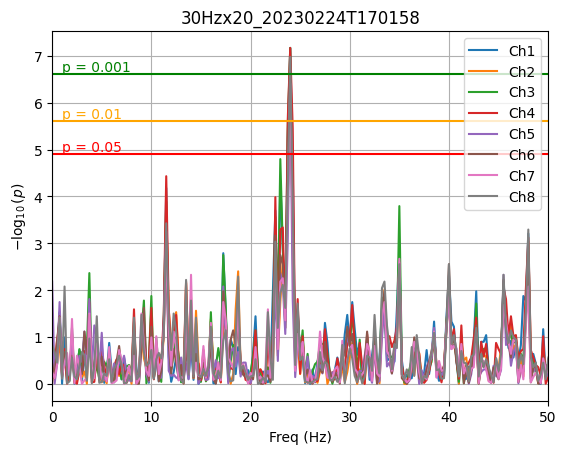

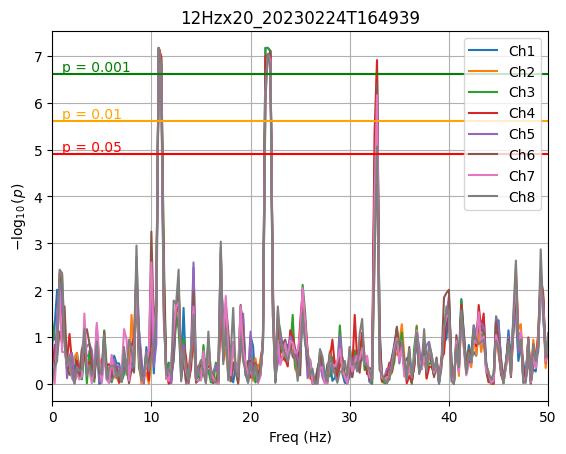

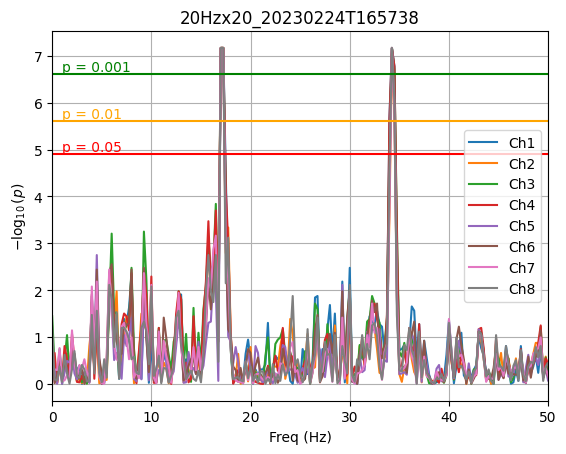

In [44]:
data_dir = Path.home() / 'ssvep_data'

for data_fname in (data_dir / 'SSVEP_S1').glob('*.txt'):

    settings = OfflineStatsSettings(
        replay_settings = MessageReplaySettings(
            filename = data_fname
        ),
        stats_settings = SpectralStatsSettings(
            time_axis = 'time',
            integration_time = 4.0,
            multiple_comparisons = False
        )
    )

    system = OfflineStats(settings)

    ez.run(system, force_single_process = True)

    stats: AxisArray = system.output[-1]
    freq_axis = 'freq'
    axis = stats.get_axis(freq_axis)
    axis_idx = stats.get_axis_idx(freq_axis)
    freqs = (np.arange(stats.shape[axis_idx]) * axis.gain) + axis.offset
    num_tests = np.prod(stats.shape)

    fig, ax = plt.subplots()
    with stats.view2d(freq_axis) as view:
        for ch in range(view.shape[1]):
            ax.plot(freqs, view[:, ch], label = f'Ch{ch+1}')

    for thresh, color in zip([0.05, 0.01, 0.001], ['red', 'orange', 'green']):
        xthresh = -np.log10(thresh / num_tests)
        ax.axhline(xthresh, color = color)
        ax.annotate(f'p = {thresh}', (1, xthresh), va = 'bottom', color = color)

    ax.legend()

    ax.set_xlabel('Freq (Hz)')
    ax.set_ylabel(r'$-\log_{10}(p)$')
    ax.grid(True, which = 'both')
    ax.set_xlim( 0, 50.0 )

    ax.set_title(data_fname.stem)


Lossy conversion from float64 to uint8. Range [-1.0, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.0, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.0, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.0, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.0, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.0, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.0, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.0, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

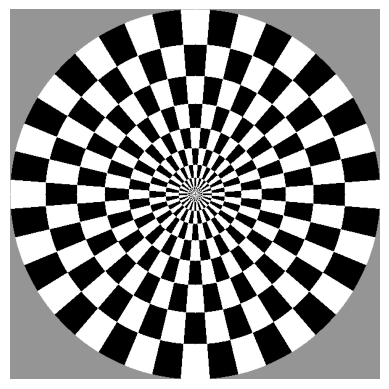

In [125]:
import numpy as np
import imageio

size = 600
rad_deg = 40 # num checkers around circle
circ = 10 # concentric checkers
circ_exp = 0.5 # warp for concentric checkers

x, y = np.meshgrid( np.arange(size), np.arange(size) )
x = (x - (size / 2.0))/(size / 2.0)
y = (y - (size / 2.0))/(size / 2.0)

dist = np.sqrt(x**2 + y**2) ** circ_exp
angle = np.arctan2(y,x)

image = np.sin(2 * np.pi * (circ / 2) * dist) * np.cos(angle * rad_deg / 2)

image = np.sign(image)
image[np.where(dist > 1.0)] = 0 

fig, ax = plt.subplots()
ax.axis('off')
ax.imshow(image, cmap = plt.cm.Greys)

# gif supports integer multiples of 10ms frame periods
# additionally, almost no browsers support 100 fps gifs
fps = 50

# Given 50 fps, we get 10 hz reversal frequency by flipping
# image every 5 frames.  We only care about reversals; not full period
stimuli = [
    (10, 5),
    (12.5, 4),
    (16.33, 3),
    (25, 2),
]

for freq, frames in stimuli:
    anim = ([image] * frames) + ([image * -1] * frames)
    imageio.mimsave(f'{freq}Hz.gif', anim, fps=50)